# 0. Используемые библиотеки

In [1]:
import numpy as np  # библиотека для работы с числовыми данными
import pandas as pd  # библиотека для обработки и анализа данных
 
import matplotlib.pyplot as plt  # библиотека для визуализации изображений датасета

import torch  # библиотека для работы с нейронными сетями 
from torch import nn  # для реализации и обучения нейронной сети
from torch.utils.data import Dataset, DataLoader  # для создания кастомного датасета и загрузки данных
import torchmetrics  # библиотека для использования метрик эффективности
import tensorboard  # библиотека для визуализации процесса обучения
from torchvision import transforms  # для преобразования изображений в тензор

import os  # библиотека для работы с интерфейсами операционной системы

from skimage import io  # для работы с изображениями
from PIL import Image  # для работы с изображениями

import lightning.pytorch as pl  # библиотека для автоматизации процесса оптимизации обучения
from lightning.pytorch import Trainer  # для обучения модели

import timm  # библиотека с предобученными моделями 

from sklearn.metrics import accuracy_score, f1_score  # для проверки качества модели с помощью sklearn

import time  # для замера времени

**Задачей** в данной работе является выявление фактов наличия повреждений автомобиля.

# 1. Подготовка датасета

Для решения задачи классификации был получен датасет, содержащий изображения автомобилей Hyundai Solaris и соответсвующие разметки повреждений.
#### Пример изображений: 

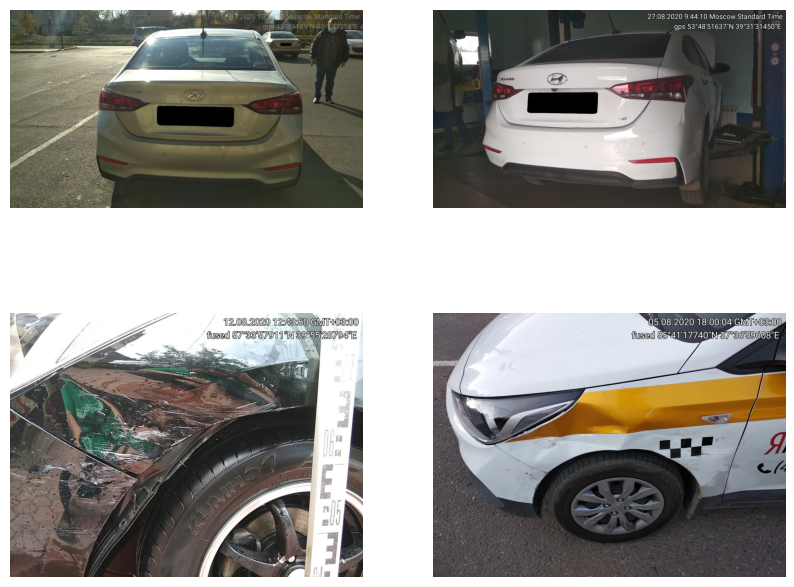

In [3]:
folder_dir = 'C:\\Users\\Анастасия\\CourseWork\\solaris_damage_0_4_3\\images'
images_list =  os.listdir(folder_dir)  # список названий изображений
indexes = np.random.randint(0, len(images_list), size=4)  # случайные индексы для визуализации 

fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(len(indexes)):
    image = Image.open(folder_dir + '\\' + images_list[indexes[i]], mode='r')
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

Изначально датасет был разделён на трейновый и валидационный. Этот этап предполагался после предобработки и анализа данных, поэтому было принято решение объединить их в один:

In [4]:
df_train = pd.read_json('solaris_damage_0_4_3/train_damage.json').T  # считывание даных в датафрейм
df_val = pd.read_json('solaris_damage_0_4_3/val_damage.json').T  # считывание даных в датафрейм

data = pd.concat([df_train, df_val])
data.head() 

,fileref,size,filename,base64_img_data,file_attributes,regions
837010425_ph-1612345459140.jpg463108,,463108,837010425_ph-1612345459140.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
755222515_ph-1592810208762.jpg243985,,243985,755222515_ph-1592810208762.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
776217682_ph-1598080258160.jpg414012,,414012,776217682_ph-1598080258160.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
791808053_ph-1601632702874.jpg576829,,576829,791808053_ph-1601632702874.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
760090860_ph-1594117414434.jpg506029,,506029,760090860_ph-1594117414434.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."


In [5]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество столбцов датафрейма: {data.shape[1]}')

Количество строк датафрейма: 4273
Количество столбцов датафрейма: 6


Столбец **regions** представляет собой набор словарей, содержащих информацию о повреждениях автомобилей в виде кривой, задающейся с помощью списка координат, находящихся под ключами **all_points_x** и **all_points_y**.

В процессе анализа данных было выявлено, что записи для неповреждённых автомобилей в столбце **regions** содержат пустой словарь, поэтому было принято решение создать колонку **damage**, в которой будет храниться:

0 - если автомобиль не повреждён\
1 - если автомобиль повреждён

In [6]:
damage = np.where(data['regions'] != {}, 1, 0)  # функция, возвращающая массив из 0 и 1 в зависимости от условия
data['damage'] = damage  # дабавление столбца
data.head() 

,fileref,size,filename,base64_img_data,file_attributes,regions,damage
837010425_ph-1612345459140.jpg463108,,463108,837010425_ph-1612345459140.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
755222515_ph-1592810208762.jpg243985,,243985,755222515_ph-1592810208762.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
776217682_ph-1598080258160.jpg414012,,414012,776217682_ph-1598080258160.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
791808053_ph-1601632702874.jpg576829,,576829,791808053_ph-1601632702874.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
760090860_ph-1594117414434.jpg506029,,506029,760090860_ph-1594117414434.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1


Теперь мы получили датасет, в явном виде содержащий целевую переменную.
#### Визуализируем данные:

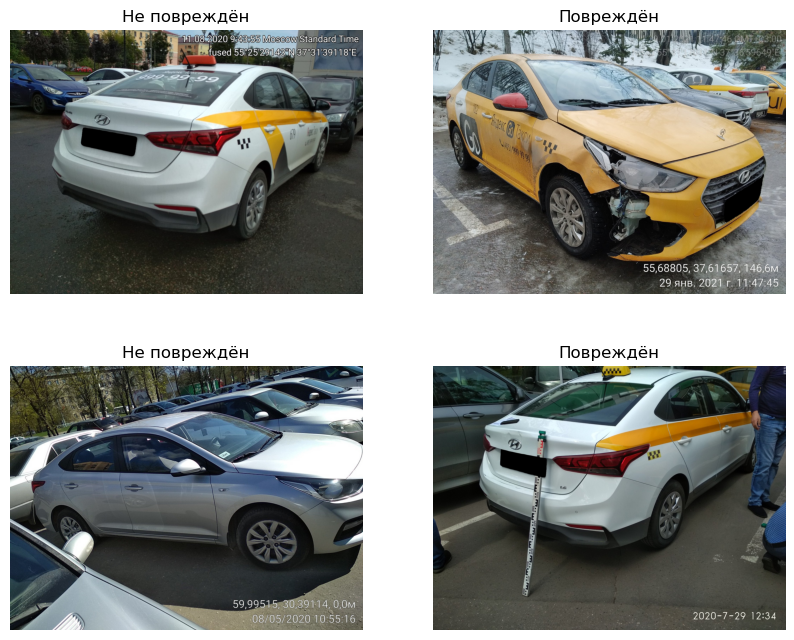

In [14]:
indexes = np.random.randint(0, len(images_list), size=4)  # случайные индексы для визуализации

fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(len(indexes)):
    image = Image.open(folder_dir + '\\' + data['filename'][indexes[i]], mode='r')
    axes[i].imshow(image, cmap='gray')
    if data['damage'][indexes[i]] == 1:
        title = 'Повреждён'
    else:
        title = 'Не повреждён'
    axes[i].set_title(title)
    axes[i].axis('off')

In [15]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество изображений: {len(images_list)}')

Количество строк датафрейма: 4273
Количество изображений: 4102


Кроме того, оказалось, что количество записей датафрейма несколько больше количества изображений, поэтому было принято решение оставить только те строки, для которых есть фотографии.

Отбор записей был осуществлён с помощью проверки каждого значения столбца **filename** на вхождение в список названий изображений, полученный ранее:

In [16]:
data = data[data['filename'].isin(images_list)]

In [17]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество изображений: {len(images_list)}')

Количество строк датафрейма: 4087
Количество изображений: 4102


Мы видим, что количество изображений превышает количество записей, но это не так критично. Теперь мы уверены, что для каждой строки датафрейма найдётся фотография.

Выведем размер каждого класса:

In [18]:
print(f'Количество повреждённых автомобилей: {data["damage"].value_counts()[1]}\n\
Количество неповреждённых автомобилей: {data["damage"].value_counts()[0]}')

Количество повреждённых автомобилей: 2534
Количество неповреждённых автомобилей: 1553


Отношение неповреждённых автомобилей к повреждённым примерно **2:3**, поэтому можно сказать, что явное доминирование одного класса над другим отсутствует.

# 2. Создание кастомного датасета

Стоит отметить, что модели для обучения используют объекты класса **DataLoader**, одним из атрибутов которого является датасет. Кроме того, модель работает с изображением, представленным в виде тензора.

Нам необходимо создать кастомный датасет, который будет содержать в себе изображение в виде тензора, а также значение класса.
#### Выбор данных:

In [11]:
images = data['filename'].values  # имена изображений, передаваемые в атрибут класса
damages = data['damage'].values  # повреждения, передаваемые в атрибут класса в виде 0 и 1

Для создания кастомного датасета было необходимо, чтобы все изображения имели одинаковый размер, поэтому с помощью метода **Resize** они были приведены к единому размеру: 

In [12]:
trans =  transforms.Compose([
                        transforms.ToTensor(),  # требуемый тип данных
                        transforms.Resize(size=(400, 600))  # новый размер картинки
])

Затем был создан класс **DamageDataset**, родительским классом которого является класс **Dataset** из torch.utils.data: 

In [13]:
class DamageDataset(Dataset):

    def __init__(self, images, damages, root_dir, transform=None):  
        self.images = images  # инициализируем изображения
        self.damages = damages  #  инициализируем повреждения
        self.root_dir = root_dir  #  инициализируем корневую папку
        self.transform = transform  # инициализируем преобразования
        
    def __len__(self):  #  возвращаеm количество элементов
        return len(self.damages)  
    
    def __getitem__(self, idx):  # загружаем и возвращаем выборку из набора данных с заданным индексом
        if torch.is_tensor(idx):  
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])  # получаем путь изображения
        image = self.transform(io.imread(img_name))  # преобразовываем изображение в тензор
        damage = torch.tensor(self.damages[idx]).to(torch.int64)  # преобразовываем целевую переменную
        
        sample = (image, damage)

        return sample

#### Создание объекта класса:

In [14]:
damage_dataset = DamageDataset(images = images, 
                               damages = damages, 
                               root_dir = folder_dir,
                               transform = trans
)

В итоге мы получаем набор кортежей, содержащих изображение и класс в виде тензоров.
#### Пример:

In [19]:
class_names = {0 : 'Не поврежден', 1 : 'Поврежден'}

In [18]:
damage_dataset[0][0]  # изображение в виде тензора

tensor([[[0.9995, 0.9999, 0.9886,  ..., 0.4051, 0.5468, 0.2043],
         [0.9841, 0.9966, 0.9986,  ..., 0.4455, 0.5066, 0.2281],
         [0.9919, 0.9855, 0.9963,  ..., 0.3973, 0.2966, 0.2915],
         ...,
         [0.3271, 0.3278, 0.3407,  ..., 0.8253, 0.8038, 0.7727],
         [0.2863, 0.3584, 0.3956,  ..., 0.8435, 0.8401, 0.8153],
         [0.2917, 0.3032, 0.3376,  ..., 0.8030, 0.8285, 0.8464]],

        [[0.9995, 0.9999, 0.9924,  ..., 0.4038, 0.5451, 0.2009],
         [0.9763, 0.9888, 0.9944,  ..., 0.4415, 0.5009, 0.2180],
         [0.9919, 0.9855, 0.9963,  ..., 0.3855, 0.2849, 0.2904],
         ...,
         [0.3282, 0.3255, 0.3251,  ..., 0.8213, 0.7999, 0.7661],
         [0.2941, 0.3561, 0.3799,  ..., 0.8317, 0.8283, 0.8025],
         [0.2996, 0.3031, 0.3298,  ..., 0.7872, 0.8091, 0.8268]],

        [[0.9919, 0.9924, 0.9734,  ..., 0.4155, 0.5421, 0.1985],
         [0.9959, 0.9977, 0.9997,  ..., 0.4640, 0.5211, 0.2431],
         [0.9981, 0.9922, 0.9986,  ..., 0.4129, 0.3207, 0.

In [19]:
damage_dataset[0][1]  # класс в виде тензора

tensor(1)

# 3. Разбиение датасета

Прежде чем перейти к обучению, я разбила датасет на две части: на трейновый и тестовый в соотношении 4:1. На трейновом датасете модель будет обучаться, на тестовом - проверяться. 

In [20]:
seed = torch.Generator().manual_seed(42)

train_to_valid_size = int(len(damage_dataset) * 0.8)  # размер трейнового датасета до разбиения на валидационный
test_size = len(damage_dataset) - train_to_valid_size  # размер тестового датасета

train_to_valid_set, test_set = torch.utils.data.random_split(damage_dataset, [train_to_valid_size, test_size], generator=seed)

Затем 20% от трейнового датасета было отведено на валидационный. Наличие трейнового и валидационного датасетов объясняется необходимостью построения графиков показателей качества модели, с помощью которых будет отслеживаться факт недо- или переобучения.

In [21]:
train_size = int(len(train_to_valid_set) * 0.8)  # размер трейнового датасета после разбиения на валидационный
valid_size = len(train_to_valid_set) - train_size  # размер валидационного датасета

train_set, valid_set = torch.utils.data.random_split(train_to_valid_set, [train_size, valid_size], generator=seed)

Кроме того, была создана переменная, отвечающая за количество классов. Она является одним из параметров модели.

In [22]:
num_classes = data['damage'].nunique()  # количесвто классов

# 4. Описание моделей

Для данной работы были выбраны модели RexNet26, Darknet54, ResNet34.

### ResNet

ResNet - сокращённое название от Residual Network, которое можно дословно перевести как «остаточная сеть». Оно соответствует идее ResNet, которая заключается в ведении остаточных блоков, содержащих «обходную связь идентичности», обходящую один или несколько слоев.

Данное введение помогло справиться с проблемой исчезающих градиентов, которая возникала из-за того, что множество функций активации сокращают большое входное пространство до гораздо меньшего выходного, из чего следует, что производная становится намного меньше.

Это важно, поскольку цель повышения количества слоев, как правило, нахождение идеальных весов и порогов с помощью последовательных прямых проходов, расчетов функции потерь и обратных распространений. Процесс обратного распространения находит производные всей сети, продвигаясь от последнего слоя к первому. Используя цепное правило вычисления, производные каждого слоя умножаются друг на друга. Это повторяющееся умножение может сделать производные бесконечно малыми, из чего следует, что веса и пороги входных слоев не будут эффективно обновляться в каждой сессии обучения. Поскольку эти входные слои критически важны для распознавания ключевых элементов входных данных, это может привести к неточности всей сети.


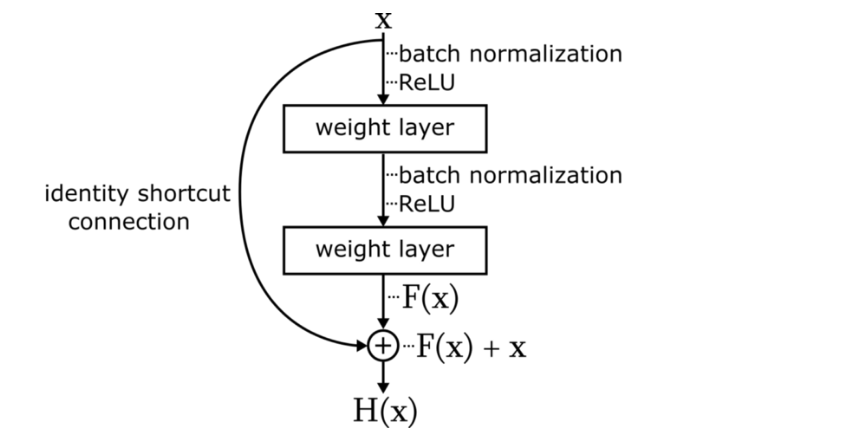

Введённый остаточный блок изменяет цель набора слоев с обучения идеальных весов и порогов F(x) на обучение выхода остаточного блока H(x) = F(x) + x. Если переставить члены уравнения, можно получить следующее выражение: F(x) = H(x) – x, которое означает, что остаточный блок пытается обучать вход минус выход, иными словами, остаточную функцию F(x) – отсюда и название «остаточный блок».

Структура модели выглядит следующим образом:

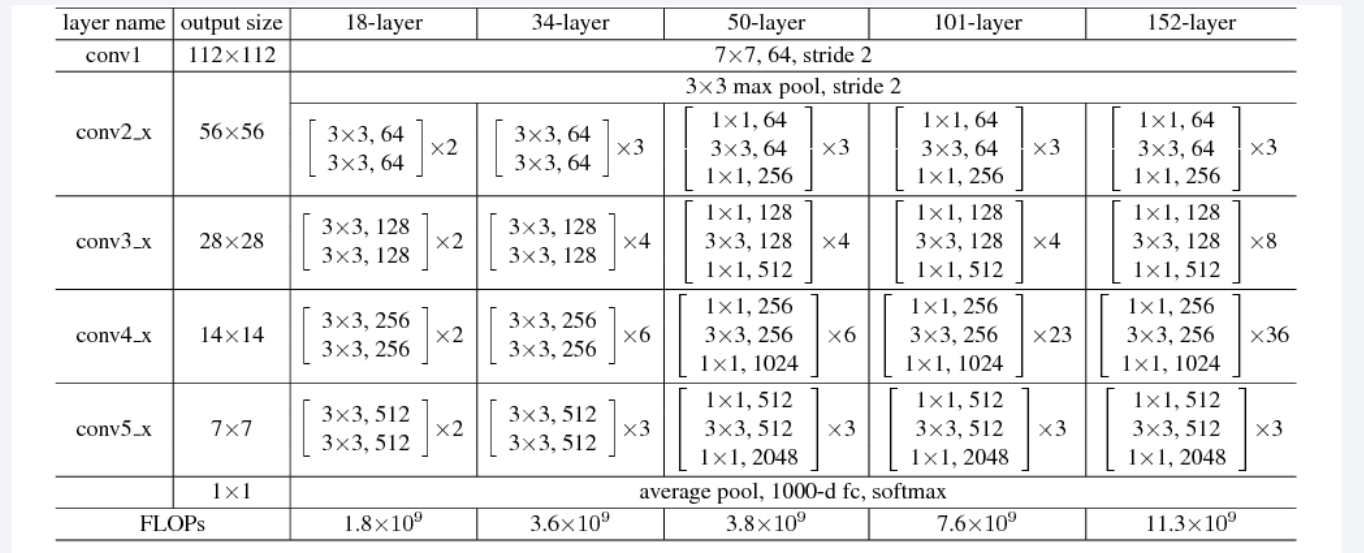

В выбранных для решения моделях ResNet после названия следует число, которое отвечает за количество свёрточных слоёв. 

### Darknet

Darknet53 - свёрточная нейронная сеть, глубина которой составляет 53 свёрточных слоя, по струтуре напоминающая Resnet. Как и Residual Network, она имеет остаточные блоки. Структура модели выглядит следующим образом:

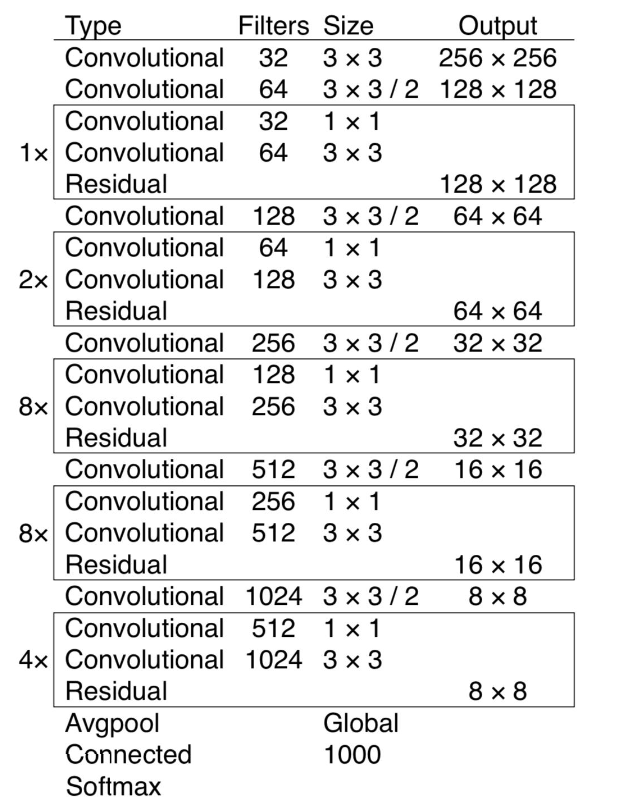

По результатам сбора информации оказалось, что скорость обучения Darknet53 выше, чем у моделей Resnet с большим числом слоёв. Однако, данная модель уступает по времени обучения моделям Resnet с меньшим количеством слоёв, но это не гарантирует высокие показатели качества в данной задаче.

# 5. Обучение моделей

### ResNet26

С помощью библиотеки предобученных моделей **timm** была создана model1 с количеством выходных значений равным значению num_classes, полученному ранее:

In [25]:
model1 = timm.create_model('resnet26', pretrained = True, num_classes = num_classes)  # создание модели
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Т.к. все модели, используемые в данной работе, предобученные, был разморожен только последний линейный слой, отвечающий за классификацию:

In [27]:
for i, (name, param) in enumerate(model1.named_parameters()):
    if 'fc' in name:
        print(name)
        continue
    else:
        param.requires_grad = False
        
freezed, unfreezed = 0, 0
for i, param in enumerate(model1.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

fc.weight
fc.bias
Замороженных слоев: 87
Незамороженных: 2


Затем был создан класс **resnet26**, родительским классом которого является **pl.LightningModule**, автоматизирующий процесс оптимизации обучения модели:

In [100]:
class resnet26(pl.LightningModule):
    def __init__(self, batch_size=10, learning_rate=1e-3):
        super().__init__()
        self.model = model1  # инициализируем модель
        self.batch_size = batch_size  # инициализируем размер батча
        self.learning_rate = learning_rate  # инициализируем скорость обучения
        self.train_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)   
        self.valid_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)  
        self.test_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)  
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        
    def forward(self, x):
        return self.model(x)  # прямой проход 
    
    def training_step(self, batch, batch_idx):        
        X, y = batch  # картинки в виде тензоров и класс
        train_loss = nn.CrossEntropyLoss()  # объект для подсчёта функции потерь на трейне 
        pred = torch.argmax(self(X), axis = 1)  # предсказанное значение класса
        self.train_accuracy(pred, y)  # accuracy на трейне
        self.log('train_loss', train_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # расчёт значения функции потерь на трейне и добавление его в логи
        self.log('train_accuracy', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # расчёт accuracy на трейне и добавление его в логи
        return train_loss(self(X), y)  # возвращение значения функции потерь для обновления весов 
    
    def validation_step(self, batch, batch_idx):        
        X, y = batch  # картинки в виде тензоров и класс
        validation_loss = nn.CrossEntropyLoss()  # объект для подсчёта функции потерь на валидации
        pred = torch.argmax(self(X), axis = 1)  # предсказанное значение класса
        self.valid_accuracy(pred, y)  # accuracy на валидации
        self.log('validation_loss', validation_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # расчёт значения функции потерь на валидации и добавление его в логи
        self.log('validation_accuracy', self.valid_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # расчёт accuracy на валидации и добавление его в логи
        
    def test_step(self, batch, batch_idx):        
        X, y = batch  # картинки в виде тензоров и класс
        pred = torch.argmax(self(X), axis = 1)  # предсказанное значение класса
        self.test_accuracy(pred, y)  # accuracy на тесте
        self.F1(pred, y)  # F1 на тесте
        self.log('test_accuracy', self.test_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # добавление accuracy на тесте в логи
        self.log('F1-score', self.F1, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)  # добавление F1 на тесте в логи
        
    def predict_step(self, batch, batch_idx):  # для метрик из sklearn       
        X, y = batch  # картинки в виде тензоров и класс
        y_hat = self(X)  # вероятности принадлежности к классу  
        return torch.argmax(y_hat, axis = 1), y  # предсказанный и истинный класс     
                                                    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)  # оптимайзер
        return optimizer  # возвращение оптимайзера для обновления весов

Создание объекта класса **resnet26**:

In [101]:
model_pl1 = resnet26()

Затем были созданы объекты даталоадеров с заданными батчсайзами для использования их в обучении:  

In [102]:
train_loader1 = DataLoader(train_set, batch_size = 30, shuffle = True)
test_loader1 = DataLoader(test_set, batch_size = 30, shuffle = True)
valid_loader1 = DataLoader(valid_set, batch_size = 30, shuffle = True)

Для обучения необходимо было создать объект класса **Trainer**, предназначенный для обновления гиперпараметров модели. К нему был применён метод **fit** c соответствующими даталоадерами.\
С помощью бибилотеки **time** был произведён расчёт времени обучения модели.

In [103]:
start_time1 = time.time()
trainer = Trainer(limit_train_batches = 10**9, max_epochs = 60)
trainer.fit(model_pl1, train_loader1, valid_loader1)
finish_time1 = time.time()
training_time1 = finish_time1 - start_time1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\nicol\NN\КУРСАЧ\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params
--------------------------------------------------
0 | model          | ResNet         | 21.3 M
1 | train_accuracy | BinaryAccuracy | 0     
2 | valid_accuracy | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
4 | F1             | BinaryF1Score  | 0     
--------------------------------------------------
1.0 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consis

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


Для визуализации был использован **tensorboard**. Далее можно увидеть графики accuracy и значений функции потерь на трейновом и валидационном датасетах:

In [8]:
%reload_ext tensorboard
%tensorboard --logdir model1_resnet26_log --bind_all

Reusing TensorBoard on port 6006 (pid 1912), started 0:01:02 ago. (Use '!kill 1912' to kill it.)

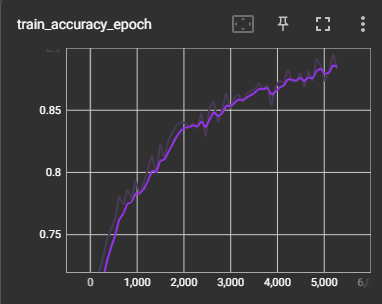

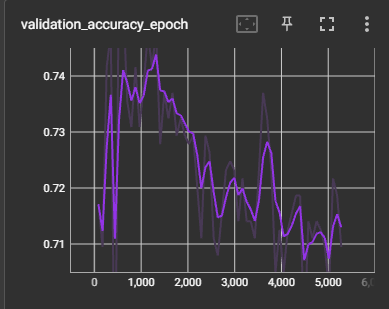

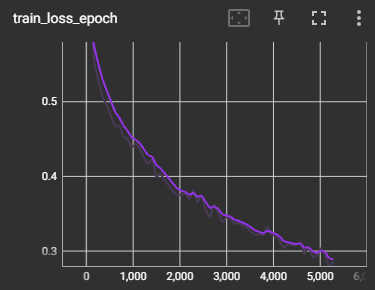

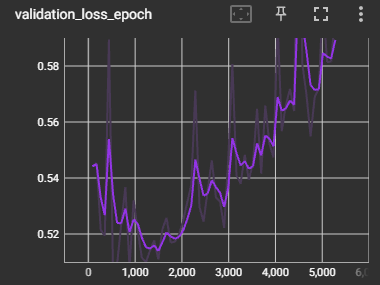

Глядя на полученные результаты, можно заметить, что в определённый момент значения accuracy на валидационном датасете начали убывать, в то время как значения accuracy на трейновом датасете продолжали расти. На этом же моменте значения функции потерь на валидационном датасете начали увеличиваться, на трейновом - продолжали снижаться. Данный факт может свидетельствовать о наличии переобучения модели, которое началось примерно на 1500 батче.

Далее модель предсказывала классы для изображений тестового даталоадера.\
Были получены следующие значения метрик accuracy и F1:

In [104]:
metrics1 = trainer.test(model_pl1, test_loader1)[0]
metrics1['training_time'] = training_time1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      F1-score_epoch       │    0.7270811200141907     │
│    test_accuracy_epoch    │    0.6833741068840027     │
└───────────────────────────┴───────────────────────────┘

Изначально модели выдавали неккоректные значения (в итоге ошибка была исправлена), поэтому воспользовавшись методом **predict** и метриками sklearn, я дополнительно рассчитала accuracy и F1, сохранив их в файлы: 

In [105]:
pred_true = trainer.predict(model_pl1, test_loader1) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [106]:
pred = torch.vstack([i[0].reshape(-1, 1) for i in pred_true])
true = torch.vstack([i[1].reshape(-1, 1) for i in pred_true])
metrics = [accuracy_score(pred.numpy(), true.numpy()), f1_score(pred.numpy(), true.numpy()), training_time1]
df_resnet26 = pd.DataFrame(metrics).T
df_resnet26.columns = metrics1.keys()
df_resnet26.to_excel('df_resnet26.xlsx')

In [20]:
metrics_resnet26 = pd.read_excel('df_resnet26.xlsx', index_col=0)
metrics_resnet26

,test_accuracy_epoch,F1-score_epoch,training_time
0,0.683374,0.727081,17161.4607


После того, как ошибка была исправлена, метрики из библиотеки **torchmetrics** совпали с метриками библиотеки **sklearn**.

In [64]:
torch.save(model_pl1, 'model1_resnet26')  # сохранение модели

### Darknet53

Дальнейшие действия (создание модели, разморозка слоёв, создание класса, даталоадеров, обучение модели и расчёт метрик эффективности) значительно не отличаются от действий, произведённых для модели resnet26, поэтому комментарии будут опущены.  

In [24]:
model2 = timm.create_model('darknet53', pretrained = True, num_classes = num_classes)
model2

CspNet(
  (stem): Sequential(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
  )
  (stages): Sequential(
    (0): DarkStage(
      (conv_down): ConvNormActAa(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (aa): Identity()
      )
      (blocks): Sequential(
        (0): DarkBlock(
          (conv1): ConvNormAct(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, mom

In [25]:
for i, (name, param) in enumerate(model2.named_parameters()):
    if 'fc' in name:
        print(name)
    else:
        param.requires_grad = False

freezed, unfreezed = 0, 0
for i, param in enumerate(model2.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

head.fc.weight
head.fc.bias
Замороженных слоев: 156
Незамороженных: 2


In [29]:
class darknet53(pl.LightningModule):
    def __init__(self, batch_size=10, learning_rate=1e-3):
        super().__init__()
        self.model = model2
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.valid_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.losses = []
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):        
        X, y = batch
        train_loss = nn.CrossEntropyLoss()  
        pred = torch.argmax(self(X), axis = 1)
        self.train_accuracy(pred, y)
        self.log('train_loss', train_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('train_accuracy', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        return train_loss(self(X), y)
    
    def validation_step(self, batch, batch_idx):        
        X, y = batch
        validation_loss = nn.CrossEntropyLoss()
        pred = torch.argmax(self(X), axis = 1)
        self.valid_accuracy(pred, y)
        self.log('validation_loss', validation_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('validation_accuracy', self.valid_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def test_step(self, batch, batch_idx):        
        X, y = batch
        pred = torch.argmax(self(X), axis = 1)
        self.test_accuracy(pred, y) 
        self.F1(pred, y)
        self.log('test_accuracy', self.test_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('F1-score', self.F1, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def predict_step(self, batch, batch_idx):       
        X, y = batch
        y_hat = self(X)
        return torch.argmax(y_hat, axis = 1), y     
                                                    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [30]:
model_pl2 = darknet53()

In [31]:
train_loader2 = DataLoader(train_set, batch_size = 20, shuffle = True)
test_loader2 = DataLoader(test_set, batch_size = 20, shuffle = True)
valid_loader2 = DataLoader(valid_set, batch_size = 20, shuffle = True)

In [32]:
import time 
start_time2 = time.time()
trainer2 = Trainer(limit_train_batches = 10**9, max_epochs = 40)
trainer2.fit(model_pl2, train_loader2, valid_loader2)
finish_time2 = time.time()
training_time2 = finish_time2 - start_time2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\nicol\NN\КУРСАЧ\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params
--------------------------------------------------
0 | model          | CspNet         | 40.6 M
1 | train_accuracy | BinaryAccuracy | 0     
2 | valid_accuracy | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
4 | F1             | BinaryF1Score  | 0     
--------------------------------------------------
2.0 K     Trainable params
40.6 M    Non-trainable params
40.6 M    Total params
162.348   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consis

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [4]:
%reload_ext tensorboard
%tensorboard --logdir model2_darknet53_log --host localhost

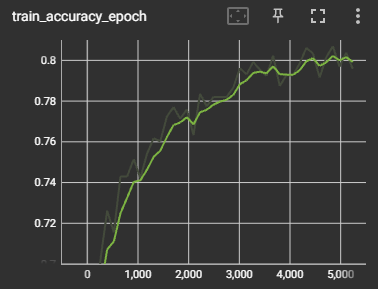

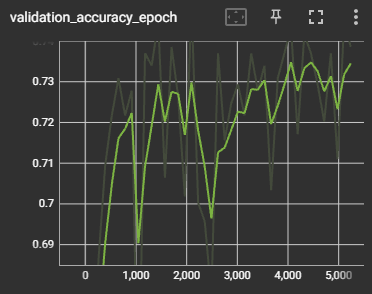

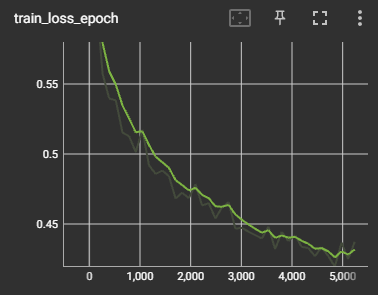

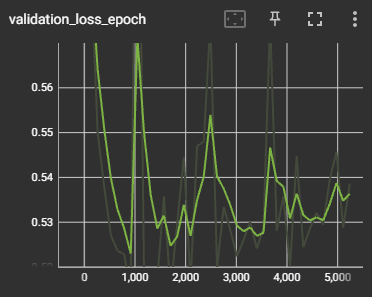

Глядя на полученные результаты, можно сказать, что явных признаков переобучения не наблюдается, хотя заметны колебания значений accuracy и значений функции потерь.  

In [33]:
metrics_2 = trainer2.test(model_pl2, test_loader2)[0]
metrics_2['training_time'] = training_time2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      F1-score_epoch       │    0.7289719581604004     │
│    test_accuracy_epoch    │    0.6809291243553162     │
└───────────────────────────┴───────────────────────────┘

In [34]:
pred_true2 = trainer2.predict(model_pl2, test_loader2) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [35]:
pred2 = torch.vstack([i[0].reshape(-1, 1) for i in pred_true2])
true2 = torch.vstack([i[1].reshape(-1, 1) for i in pred_true2])
metrics2 = [accuracy_score(pred2.numpy(), true2.numpy()), f1_score(pred2.numpy(), true2.numpy()), training_time2]
df_darknet53 = pd.DataFrame(metrics2).T
df_darknet53.columns = metrics_2.keys()
df_darknet53.to_excel('df_darknet53.xlsx')

In [21]:
metrics_darknet53 = pd.read_excel('df_darknet53.xlsx', index_col=0)
metrics_darknet53

,test_accuracy_epoch,F1-score_epoch,training_time
0,0.680929,0.728972,17358.031888


In [37]:
torch.save(model_pl2, 'model2_darknet53')  # сохранение модели

### ResNet34

In [35]:
model3 = timm.create_model('resnet34', pretrained = True, num_classes = num_classes)
model3

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\resnet34-43635321.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [63]:
for i, (name, param) in enumerate(model3.named_parameters()):
    if 'fc' in name:
        print(name)
    else:
        param.requires_grad = False

freezed, unfreezed = 0, 0
for i, param in enumerate(model3.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

fc.weight
fc.bias
Замороженных слоев: 108
Незамороженных: 2


In [3]:
class resnet34(pl.LightningModule):
    def __init__(self, batch_size=10, learning_rate=1e-3):
        super().__init__()
        self.model = model3
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.valid_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.losses = []
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):        
        X, y = batch
        train_loss = nn.CrossEntropyLoss()  
        pred = torch.argmax(self(X), axis = 1)
        self.train_accuracy(pred, y)
        self.log('train_loss', train_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('train_accuracy', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        return train_loss(self(X), y)
    
    def validation_step(self, batch, batch_idx):        
        X, y = batch
        validation_loss = nn.CrossEntropyLoss()
        pred = torch.argmax(self(X), axis = 1)
        self.valid_accuracy(pred, y)
        self.log('validation_loss', validation_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('validation_accuracy', self.valid_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def test_step(self, batch, batch_idx):        
        X, y = batch
        pred = torch.argmax(self(X), axis = 1)
        self.test_accuracy(pred, y) 
        self.F1(pred, y)
        self.log('test_accuracy', self.test_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('F1-score', self.F1, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def predict_step(self, batch, batch_idx):       
        X, y = batch
        y_hat = self(X)
        return torch.argmax(y_hat, axis = 1), y     
                                                    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [76]:
model_pl3 = resnet34()

In [77]:
train_loader3 = DataLoader(train_set, batch_size = 20, shuffle = True)
test_loader3 = DataLoader(test_set, batch_size = 20, shuffle = True)
valid_loader3 = DataLoader(valid_set, batch_size = 20, shuffle = True)

In [79]:
import time 
start_time3 = time.time()
trainer3 = Trainer(limit_train_batches = 10**9, max_epochs = 70)
trainer3.fit(model_pl3, train_loader3, valid_loader3)
finish_time3 = time.time()
training_time3 = finish_time3 - start_time3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params
--------------------------------------------------
0 | model          | ResNet         | 21.3 M
1 | train_accuracy | BinaryAccuracy | 0     
2 | valid_accuracy | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
4 | F1             | BinaryF1Score  | 0     
--------------------------------------------------
1.0 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


In [75]:
%reload_ext tensorboard
%tensorboard --logdir model3_resnet34_logs --bind_all

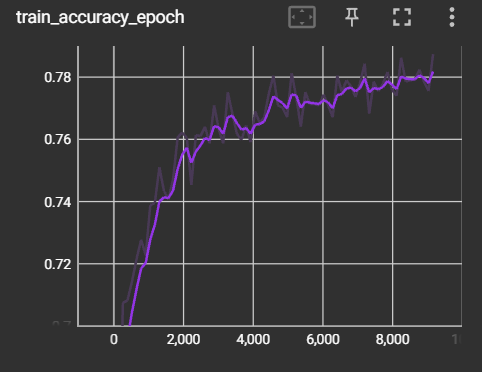

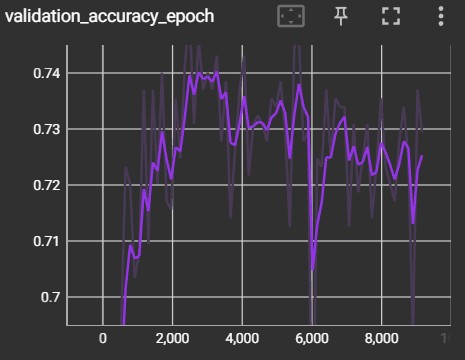

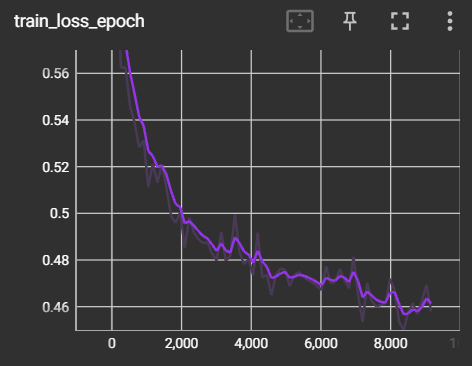

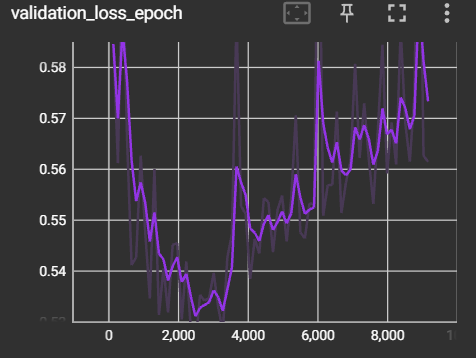

Глядя на полученные результаты, можно заметить, что поведение графика схоже с тем, которое было у модели resnet26. Переобучения модели началось примерно в промежутке с 2500 до 3500 батча.

In [80]:
metrics_3 = trainer3.test(model_pl3, test_loader3)[0]
metrics_3['training_time'] = training_time3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      F1-score_epoch       │    0.7636363506317139     │
│    test_accuracy_epoch    │    0.6980440020561218     │
└───────────────────────────┴───────────────────────────┘

In [82]:
pred_true3 = trainer3.predict(model_pl3, test_loader3) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [86]:
pred3 = torch.vstack([i[0].reshape(-1, 1) for i in pred_true3])
true3 = torch.vstack([i[1].reshape(-1, 1) for i in pred_true3])
metrics3 = [accuracy_score(pred3.numpy(), true3.numpy()), f1_score(pred3.numpy(), true3.numpy()), training_time3]
df_resnet34 = pd.DataFrame(metrics3).T
df_resnet34.columns = metrics_3.keys()
df_resnet34.to_excel('df_resnet34.xlsx')

In [22]:
metrics_resnet34 = pd.read_excel('df_resnet34.xlsx', index_col=0)
metrics_resnet34

,test_accuracy_epoch,F1-score_epoch,training_time
0,0.698044,0.763636,20515.247403


In [89]:
torch.save(model_pl3, 'model3_resnet34')  # сохранение модели

# 6. Тестирование модели

Был создан датафрейм, содержащий результаты по всем моделям и необходимый для выбора лучшей из них. Выбранная модель будет использоваться для тестирования и визуализации результатов:

In [28]:
common = pd.concat([metrics_resnet26, metrics_darknet53, metrics_resnet34], axis=0)
common.index = ['resnet26', 'darknet53', 'resnet34']
common['training_time'] = common['training_time'] / 3600  # время в часах
common

,test_accuracy_epoch,F1-score_epoch,training_time
resnet26,0.683374,0.727081,4.767072
darknet53,0.680929,0.728972,4.821676
resnet34,0.698044,0.763636,5.698680


Можно увидеть, что метрики resnet-ов больше метрики darknet-а. Кроме того, самые высокие показатели имеет resnet34, который (как было сказано ранее) с определённого момента начал переобучаться. Несмотря на это, я полагаю, что если обучить эту модель не меньшем количестве эпох (изначально их было 70), таким образом избежав переобучения, то она действительно будет самой эффективной и точной из используемых в данной работе моделей.

Таким образом, для тестирования и визуализации результатов была выбрана модель resnet34:

In [35]:
test_model = torch.load('model3_resnet34')  # загружаем модель

#### Визаулизация:

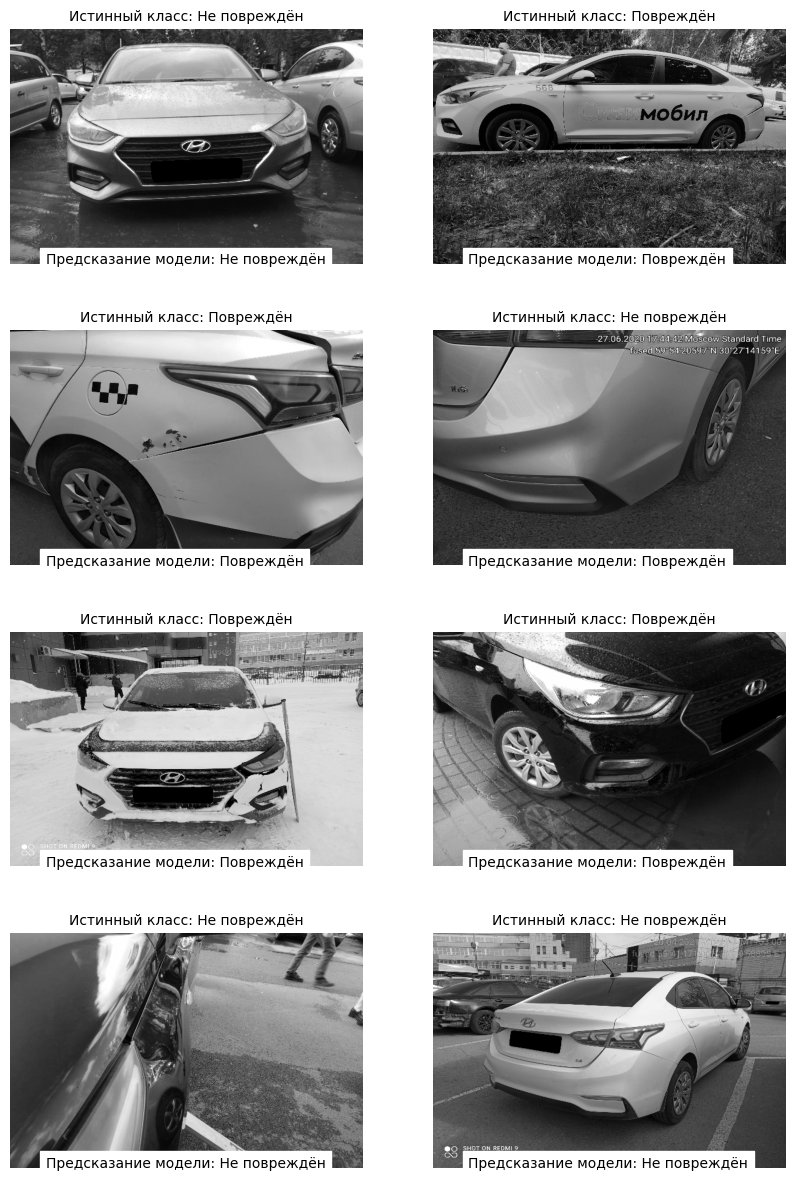

In [72]:
indexes = np.random.randint(0, damage_dataset.__len__(), size=8)  # случайные индексы для визуализации

fig, ax = plt.subplots(figsize=(10, 15), nrows=4, ncols=2) 
axes = ax.ravel()
for i in range(len(indexes)):
    image, damage = damage_dataset[indexes[i]]
    axes[i].imshow(image[0], cmap='gray')
    if damage.item() == 1:
        title = 'Истинный класс: Повреждён'
    else:
        title = 'Истинный класс: Не повреждён'
    axes[i].set_title(title, size=10)
    pred = class_names[torch.argmax(test_model(image.unsqueeze(0))).item()]
    axes[i].text(x=60, y=400, s=f'Предсказание модели: {pred}', backgroundcolor='w', size=10)
    axes[i].axis('off')

# 7. Вывод

В процессе выполнения курсовой работы была успешно проведена классификация автомобилей, направленная на разделение их на два класса: с повреждениями и без. Она была осуществлена с помощью применения свёрточных нейронных сетей.

В работе были использованы такие модели, как `resnet26`, `darknet53`, `resnet34`, для каждой из которых были рассчитаны accuracy и F1. Кроме того, были представлены графики значений функции потерь и значений accuracy на трейновых и валидационных датасетах, что помогло делать некоторые выводы относительно процесса обучения моделей.

Как уже было отмечено ранее, лучшие результаты показала **resnet34**. В дальнейшем, обучив эту модель на меньшем количестве эпох, можно добиться отсутствия переобучения и получить более высокие метрики.

Во время выполнения курсовой я приобрела большое количество знаний о том, как устроены свёрточные нейронные сети, мною были получены навыки работы как с новыми для меня библиотеками такими, как `torch`, `torchmetrics`, `tensorboard`, `lightning.pytorch`, так и с теми, которые уже встречались в процессе обучения в университете.